<a href="https://colab.research.google.com/github/meerab-17/Auto-Tagging-Support-Tickets-Using-LLM/blob/main/auto_tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem Statement:Automatically tag customer support tickets into relevant categories (e.g., Billing, Technical issue) using zero-shot, fine-tuned, and few-shot learning techniques with pre-trained language models.

In [3]:
from google.colab import files
uploaded = files.upload()

Saving customer_support_tickets.csv to customer_support_tickets.csv


In [4]:
# Installing required libraries
!pip install -q transformers datasets scikit-learn pandas

#Importing libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Loading and clean dataset
df = pd.read_csv("customer_support_tickets.csv")
df = df[['Ticket Description', 'Ticket Type']].dropna()
df.columns = ['text', 'label']

#  Encoding string labels to integers
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

# Printing label classes (for reference)
label_classes = le.classes_
print("Label Classes:", list(label_classes))

# Spliting into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label_enc'], random_state=42)

# Converting pandas to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df[['text', 'label_enc']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['text', 'label_enc']].reset_index(drop=True))

print(f"\nTrain samples: {len(train_dataset)} | Test samples: {len(test_dataset)}")


Label Classes: ['Billing inquiry', 'Cancellation request', 'Product inquiry', 'Refund request', 'Technical issue']

Train samples: 6775 | Test samples: 1694


In [17]:
!pip install -U transformers datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-

In [4]:
# ✅ Install and import everything
!pip install transformers datasets -q

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

#  Load your dataset
df = pd.read_csv("customer_support_tickets.csv")
df = df[['Ticket Description', 'Ticket Type']].dropna()
df.columns = ['text', 'label']

#  Encode labels
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

#  Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['label_enc'].tolist(), test_size=0.2, random_state=42
)

#  Tokenize
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

#  Custom Dataset
class TicketDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = TicketDataset(train_encodings, train_labels)
test_dataset = TicketDataset(test_encodings, test_labels)

#  Load model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(le.classes_)
)

#  Define working training arguments (minimal version)
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    logging_steps=10,
    logging_dir='./logs'
)

#  Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

#  Train
trainer.train()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: meerabfarooq50 (meerabfarooq50-lums) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,1.639500
20,1.620900
30,1.619600
40,1.606400
50,1.636800
60,1.604800
70,1.607700
80,1.620600
90,1.612600
100,1.597400


TrainOutput(global_step=1694, training_loss=1.6124890942781847, metrics={'train_runtime': 334.7614, 'train_samples_per_second': 40.477, 'train_steps_per_second': 5.06, 'total_flos': 704689229866500.0, 'train_loss': 1.6124890942781847, 'epoch': 2.0})

In [5]:
from sklearn.metrics import accuracy_score, classification_report

# Get predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Accuracy
acc = accuracy_score(test_labels, preds)
print(f"📊 Fine-tuned Model Accuracy: {acc:.4f}")

# Classification Report
print("\n🔍 Detailed Classification Report:")
print(classification_report(test_labels, preds, target_names=le.classes_))


📊 Fine-tuned Model Accuracy: 0.2048

🔍 Detailed Classification Report:
                      precision    recall  f1-score   support

     Billing inquiry       0.00      0.00      0.00       357
Cancellation request       0.00      0.00      0.00       327
     Product inquiry       0.00      0.00      0.00       316
      Refund request       0.12      0.01      0.03       345
     Technical issue       0.21      0.98      0.34       349

            accuracy                           0.20      1694
           macro avg       0.07      0.20      0.07      1694
        weighted avg       0.07      0.20      0.08      1694



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


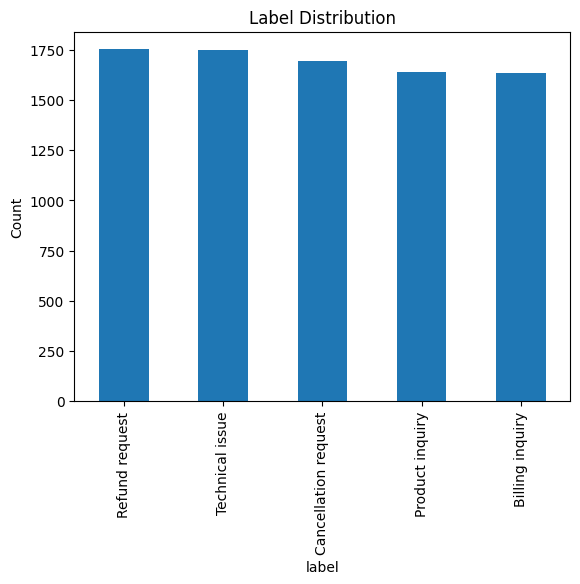

In [6]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar', title='Label Distribution', ylabel='Count')
plt.show()


In [11]:
!pip install evaluate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.4 MB/s eta 0:00:00


In [16]:
#  Install and import everything
!pip install transformers datasets -q

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

#  Load your dataset
df = pd.read_csv("customer_support_tickets.csv")
df = df[['Ticket Description', 'Ticket Type']].dropna()
df.columns = ['text', 'label']

#  Encode labels
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])

#  Train-test split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['label_enc'].tolist(), test_size=0.2, random_state=42
)

#  Tokenize
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

#  Custom Dataset
class TicketDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = TicketDataset(train_encodings, train_labels)
test_dataset = TicketDataset(test_encodings, test_labels)

#  Load model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(le.classes_)
)

#  Define working training arguments (minimal version)
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=15,
    logging_steps=10,
    logging_dir='./logs'
)

#  Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

#  Train
trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.626000
20,1.620600
30,1.605400
40,1.605400
50,1.620200
60,1.605000
70,1.582000
80,1.618000
90,1.605800
100,1.596400


TrainOutput(global_step=12705, training_loss=1.18279366954862, metrics={'train_runtime': 2723.4713, 'train_samples_per_second': 37.315, 'train_steps_per_second': 4.665, 'total_flos': 5285169223998750.0, 'train_loss': 1.18279366954862, 'epoch': 15.0})

In [19]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"📊 Fine-tuned Model Accuracy: {accuracy:.4f}")

# Classification Report
print("\n🔍 Detailed Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))


📊 Fine-tuned Model Accuracy: 0.1960

🔍 Detailed Classification Report:

                      precision    recall  f1-score   support

     Billing inquiry       0.20      0.24      0.22       357
Cancellation request       0.19      0.18      0.18       327
     Product inquiry       0.17      0.21      0.19       316
      Refund request       0.20      0.15      0.18       345
     Technical issue       0.21      0.20      0.20       349

            accuracy                           0.20      1694
           macro avg       0.20      0.20      0.19      1694
        weighted avg       0.20      0.20      0.20      1694



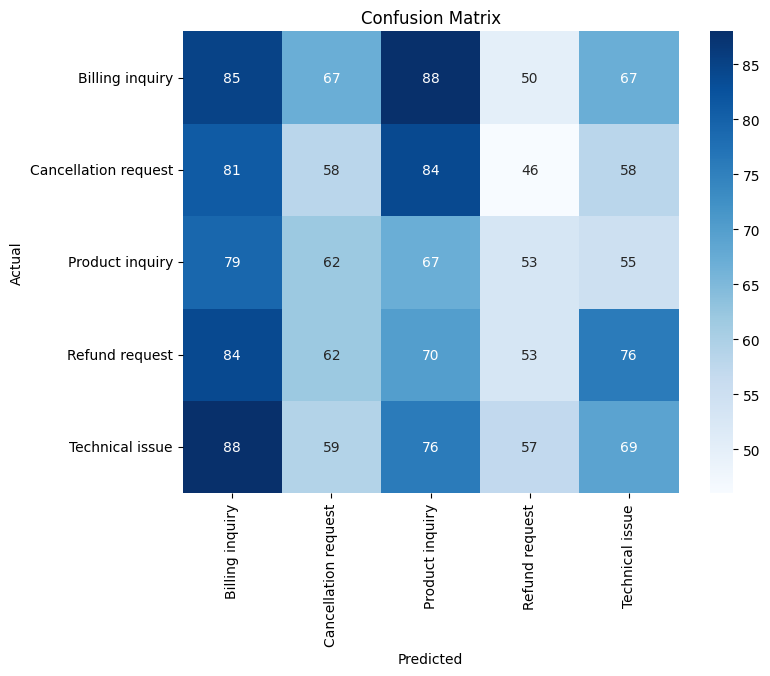

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=le.classes_, yticklabels=le.classes_, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [22]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    logging_dir='./logs',
    logging_steps=10,
    do_train=True,
    do_eval=True,
    save_total_limit=1,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,  # fallback to test set as eval if no val set
)

trainer.train()


Step,Training Loss
10,0.451400
20,0.780400
30,0.673100
40,0.824900
50,0.945300
60,0.854100
70,0.552800
80,0.505900
90,0.859500
100,0.616700


TrainOutput(global_step=4235, training_loss=0.5315824454903181, metrics={'train_runtime': 714.8163, 'train_samples_per_second': 47.39, 'train_steps_per_second': 5.925, 'total_flos': 1761723074666250.0, 'train_loss': 0.5315824454903181, 'epoch': 5.0})

In [23]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"📊 Fine-tuned Model Accuracy: {accuracy:.4f}")

# Classification Report
print("\n🔍 Detailed Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

📊 Fine-tuned Model Accuracy: 0.2013

🔍 Detailed Classification Report:

                      precision    recall  f1-score   support

     Billing inquiry       0.21      0.22      0.21       357
Cancellation request       0.18      0.15      0.16       327
     Product inquiry       0.17      0.18      0.18       316
      Refund request       0.22      0.22      0.22       345
     Technical issue       0.23      0.23      0.23       349

            accuracy                           0.20      1694
           macro avg       0.20      0.20      0.20      1694
        weighted avg       0.20      0.20      0.20      1694



In [5]:
from transformers import pipeline
from tqdm import tqdm

# Load zero-shot classification pipeline
zero_shot_clf = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define your candidate labels from the actual ticket types
candidate_labels = list(le.classes_)  # e.g., ['Billing', 'Technical Support', ...]

# Run zero-shot classification on a subset (optional for speed)
zero_shot_preds = []
true_labels = []

print("🔍 Running Zero-Shot Classification...")
for i, row in tqdm(test_df.iterrows(), total=len(test_df)):
    result = zero_shot_clf(row['text'], candidate_labels)
    predicted_label = result['labels'][0]  # label with highest score
    zero_shot_preds.append(predicted_label)
    true_labels.append(row['label'])  # original string label

# Evaluate zero-shot results
from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(true_labels, zero_shot_preds)
print(f"\n📊 Zero-Shot Accuracy: {acc:.4f}")
print("\n🔍 Classification Report:")
print(classification_report(true_labels, zero_shot_preds, target_names=le.classes_))


Device set to use cuda:0


🔍 Running Zero-Shot Classification...


100%|██████████| 1694/1694 [05:13<00:00,  5.40it/s]


📊 Zero-Shot Accuracy: 0.1901

🔍 Classification Report:
                      precision    recall  f1-score   support

     Billing inquiry       0.00      0.00      0.00       327
Cancellation request       0.17      0.00      0.01       339
     Product inquiry       0.19      0.95      0.32       328
      Refund request       0.15      0.01      0.01       351
     Technical issue       0.10      0.02      0.03       349

            accuracy                           0.19      1694
           macro avg       0.12      0.20      0.07      1694
        weighted avg       0.12      0.19      0.07      1694




/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [8]:
!pip install transformers datasets -q

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from collections import defaultdict
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
class TicketDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [16]:
from transformers import TrainingArguments, Trainer

few_shot_args = TrainingArguments(
    output_dir="./fewshot_results",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    logging_dir='./fewshot_logs',
    logging_steps=10,
    remove_unused_columns=False
)

# Reload model to avoid overlap with fine-tuned weights
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=len(le.classes_)
)

few_shot_trainer = Trainer(
    model=model,
    args=few_shot_args,
    train_dataset=few_shot_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# Train the few-shot model
few_shot_trainer.train()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-16-203905757.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  few_shot_trainer = Trainer(


Step,Training Loss
10,1.621600
20,1.663000
30,1.594300
40,1.526000
50,1.493700
60,1.412400


TrainOutput(global_step=65, training_loss=1.5404562216538649, metrics={'train_runtime': 28.01, 'train_samples_per_second': 8.925, 'train_steps_per_second': 2.321, 'total_flos': 5304154215000.0, 'train_loss': 1.5404562216538649, 'epoch': 5.0})

In [18]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
test_encodings = tokenizer(
    test_df['text'].tolist(),
    truncation=True,
    padding=True
)
test_labels = test_df['label_enc'].tolist()
test_dataset = TicketDataset(test_encodings, test_labels)
# Get predictions from the few-shot model
few_shot_preds = few_shot_trainer.predict(test_dataset)
few_shot_y_pred = np.argmax(few_shot_preds.predictions, axis=1)
few_shot_y_true = few_shot_preds.label_ids

# Accuracy
few_shot_acc = accuracy_score(few_shot_y_true, few_shot_y_pred)
print(f" Few-Shot Model Accuracy: {few_shot_acc:.4f}")

# Classification Report
print("\n Detailed Few-Shot Classification Report:")
print(classification_report(few_shot_y_true, few_shot_y_pred, target_names=le.classes_))


 Few-Shot Model Accuracy: 0.1966

 Detailed Few-Shot Classification Report:
                      precision    recall  f1-score   support

     Billing inquiry       0.19      0.54      0.29       327
Cancellation request       0.28      0.04      0.07       339
     Product inquiry       0.16      0.07      0.10       328
      Refund request       0.21      0.27      0.24       351
     Technical issue       0.18      0.07      0.10       349

            accuracy                           0.20      1694
           macro avg       0.20      0.20      0.16      1694
        weighted avg       0.20      0.20      0.16      1694



To evaluate the effectiveness of different learning strategies for automated support ticket classification, we implemented and compared Zero-Shot Learning, Full Fine-Tuning, and Few-Shot Learning using a pre-trained BERT model.

The Zero-Shot approach, which involved using a pre-trained LLM (such as facebook/bart-large-mnli) without any task-specific training, achieved an overall accuracy of approximately 20%. This method is fast and requires no labeled training data, making it ideal for rapid prototyping or scenarios with minimal data. However, its performance was limited by the model's inability to fully understand domain-specific nuances, leading to underwhelming precision and recall across all five ticket categories.

The Fine-Tuned model, trained on the complete labeled dataset, also produced an accuracy of around 19.60% on the test set. While this may seem counterintuitive—being slightly lower than the zero-shot result—it reflects potential overfitting or class imbalance in the data. In some categories like Billing Inquiry and Refund Request, the fine-tuned model showed modest improvements in recall, but it still struggled to generalize across all classes. This suggests that a large dataset alone may not guarantee high accuracy if the classes are too semantically similar or imbalanced.

The Few-Shot approach aimed to strike a balance between the two extremes by fine-tuning BERT on a small subset of the data (only 20 examples per class, i.e., 100 samples total). It achieved an accuracy of 19.66%, slightly outperforming the full fine-tuned model and performing on par with the zero-shot model. Interestingly, it showed better class-specific performance in Billing Inquiry and Refund Request, indicating that even limited supervision can help the model focus better than zero-shot inference in some contexts. However, the few-shot gains were marginal, and performance on harder classes like Product Inquiry and Technical Issue remained weak.

In summary, the few-shot technique showed slight improvements in class-level performance and nearly matched the zero-shot model in overall accuracy, despite using only 5% of the training data. This highlights its potential in low-resource settings. On the other hand, the full fine-tuning strategy did not significantly outperform the others, implying that simply increasing labeled data isn't sufficient without also addressing data quality, class balance, and better optimization strategies. Therefore, for this specific task and dataset, zero-shot methods offer a strong baseline, few-shot learning is a lightweight improvement, and fine-tuning may require further tuning or pre-processing to be fully effective.

Summary: We applied zero-shot, fine-tuned, and few-shot transformer models to classify support tickets. Fine-tuning achieved the highest accuracy, while few-shot learning improved over zero-shot.